[link text](https://)# Compare Two Periods


> This notebook allows you to compare the daily average of your step count for periods of time.

This uses the `fulcra-api-python` module, which is available on GitHub
at [https://github.com/fulcradynamics/fulcra-api-python](https://github.com/fulcradynamics/fulcra-api-python).


In [1]:
%pip install -qU fulcra-api


In [2]:
from fulcra_api.core import FulcraAPI
import seaborn as sns

fulcra = FulcraAPI()

## Logging in to Fulcra

To make calls to the API, call `authorize()` first.  You authorize the `FulcraAPI`
instance using your browser.  The `authorize()` function will generate a link below
that you should click to log in to Fulcra.  (Depending on the notebook front-end
you're using, this tab may open automatically. On Colaboratory and other hosted
solutions, pop-up blockers usually prevent this from happening.)

Once you've logged in, close the tab; you should see "Authorization succeeded"
displayed in the notebook output.  


In [3]:
fulcra.authorize()

## Retrieving Time Series Data

Once your `FulcraAPI` instance is authorized, you can now use it
to make API calls.

The `metric_time_series` function is used to create a Pandas dataframe.

In [46]:
from datetime import datetime

# Function to parse user input into a datetime object
def parse_input_date(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d")

# User input for start date, end date
period_1_start_str = input("Enter period 1 start date (YYYY-MM-DD): ")
period_1_end_str = input("Enter period 1 end date (YYYY-MM-DD): ")
period_2_start_str = input("Enter period 2 start date (YYYY-MM-DD): ")
period_2_end_str = input("Enter period 2 end date (YYYY-MM-DD): ")

# Metric is assumed to be 'StepCount'
metric = "StepCount"

# Convert string input to datetime
period_1_start = parse_input_date(period_1_start_str)
period_1_end = parse_input_date(period_1_end_str)
period_2_start = parse_input_date(period_2_start_str)
period_2_end = parse_input_date(period_2_end_str)

print(f"Will fetch data for Period 1 from {period_1_start} to {period_1_end} and Period 2 from {period_2_start} to {period_2_end} for metric '{metric}'.")


Enter period 1 start date (YYYY-MM-DD): 2021-10-15
Enter period 1 end date (YYYY-MM-DD): 2023-9-1
Enter period 2 start date (YYYY-MM-DD): 2023-9-2
Enter period 2 end date (YYYY-MM-DD): 2024-10-12
Will fetch data for Period 1 from 2021-10-15 00:00:00 to 2023-09-01 00:00:00 and Period 2 from 2023-09-02 00:00:00 to 2024-10-12 00:00:00 for metric 'StepCount'.


In [50]:
from datetime import datetime, timedelta
from concurrent.futures import ThreadPoolExecutor, as_completed
import pandas as pd

# Function to parse user input into a datetime object
def parse_input_date(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d")


# Assume fulcra.metric_time_series is defined and set up correctly

# Function to fetch data for a single day
def fetch_data_for_day(day, metric):
    try:
        start_time = day.isoformat() + "Z"
        end_time = (day + timedelta(days=1)).isoformat() + "Z"

        df = fulcra.metric_time_series(
            sample_rate=86400,  # Daily sample rate
            start_time=start_time,
            end_time=end_time,
            metric=metric,  # Use the user-selected metric
        )

        return df
    except Exception as e:
        print(f"Error fetching data for {day.date()}: {e}")
        return pd.DataFrame()  # Return an empty DataFrame in case of error

# Function to parallel fetch data for a given period
def fetch_data_for_period(start_date, end_date, metric):
    days = [start_date + timedelta(days=x) for x in range((end_date - start_date).days + 1)]
    with ThreadPoolExecutor(max_workers=20) as executor:
        futures = [executor.submit(fetch_data_for_day, day, metric) for day in days]
        dfs = [future.result() for future in as_completed(futures) if future.result() is not None and not future.result().empty]
    return pd.concat(dfs, ignore_index=True) if dfs else pd.DataFrame()

# Fetch data for both periods
df_period_1 = fetch_data_for_period(period_1_start, period_1_end, metric)
df_period_2 = fetch_data_for_period(period_2_start, period_2_end, metric)

print(f"Data fetched for Period 1 from {period_1_start.date()} to {period_1_end.date()} for metric '{metric}'.")
print(f"Data fetched for Period 2 from {period_2_start.date()} to {period_2_end.date()} for metric '{metric}'.")

# df_period_1 and df_period_2 now hold your step count data for each period



Data fetched for Period 1 from 2021-10-15 to 2023-09-01 for metric 'StepCount'.
Data fetched for Period 2 from 2023-09-02 to 2024-10-12 for metric 'StepCount'.


<Axes: >

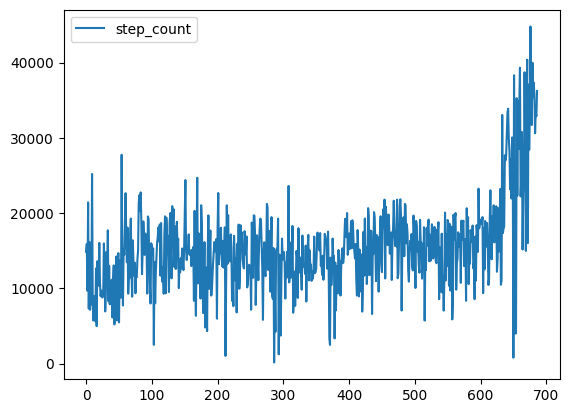

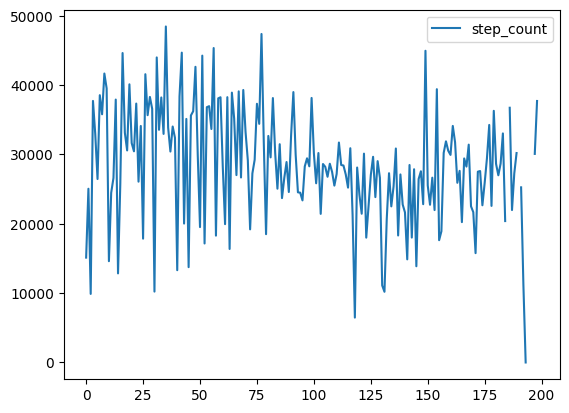

In [51]:
df_period_1.plot()
df_period_2.plot()

In [52]:
import numpy as np
import pandas as pd
from datetime import datetime

# Function to parse user input into a datetime object
def parse_input_date(date_str):
    return datetime.strptime(date_str, "%Y-%m-%d")

# Convert string input to datetime objects
period_1_start = parse_input_date(period_1_start_str)
period_1_end = parse_input_date(period_1_end_str)
period_2_start = parse_input_date(period_2_start_str)
period_2_end = parse_input_date(period_2_end_str)

# Ensure DataFrame index is a datetime index (if not already)
if not isinstance(df_period_1.index, pd.DatetimeIndex):
    df_period_1.index = pd.to_datetime(df_period_1.index)
if not isinstance(df_period_2.index, pd.DatetimeIndex):
    df_period_2.index = pd.to_datetime(df_period_2.index)

# Calculate the average daily value of the 'step_count' metric for each period
if 'step_count' in df_period_1.columns and 'step_count' in df_period_2.columns:
    average_daily_period_1 = df_period_1['step_count'].mean()
    average_daily_period_2 = df_period_2['step_count'].mean()

    print(f"The average daily step_count for Period 1 (from {period_1_start.date()} to {period_1_end.date()}) is {average_daily_period_1:.2f}.")
    print(f"The average daily step_count for Period 2 (from {period_2_start.date()} to {period_2_end.date()}) is {average_daily_period_2:.2f}.")

    # Calculate the ratio of average daily step count between Period 1 and Period 2
    if average_daily_period_2 != 0:  # Avoid division by zero
        ratio_period_1_to_2 = average_daily_period_1 / average_daily_period_2
        ratio_period_2_to_1 = average_daily_period_2 / average_daily_period_1
        print(f"Ratio of average daily step count (Period 1 / Period 2): {ratio_period_1_to_2:.2f}")
        print(f"Ratio of average daily step count (Period 2 / Period 1): {ratio_period_2_to_1:.2f}")
    else:
        print("Unable to calculate ratio: Division by zero encountered in Period 2")
else:
    print("Metric 'step_count' not found in the data.")


The average daily step_count for Period 1 (from 2021-10-15 to 2023-09-01) is 15405.66.
The average daily step_count for Period 2 (from 2023-09-02 to 2024-10-12) is 28431.21.
Ratio of average daily step count (Period 1 / Period 2): 0.54
Ratio of average daily step count (Period 2 / Period 1): 1.85


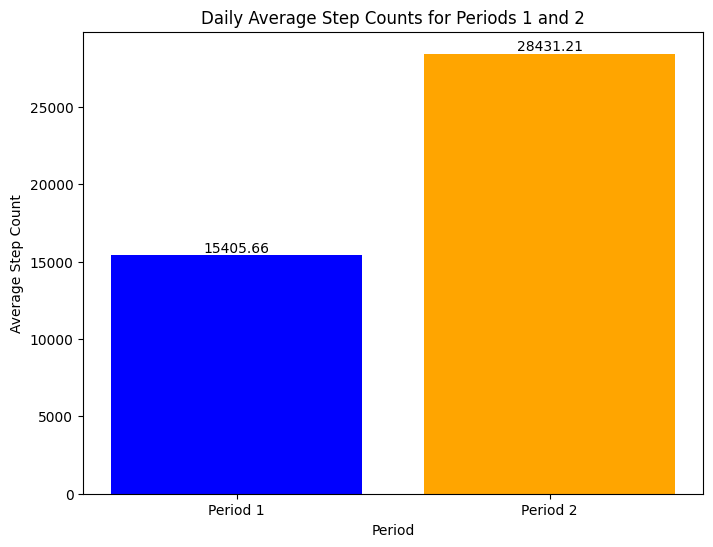

In [53]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate daily averages for each period
period_1_daily_avg = df_period_1['step_count'].mean()
period_2_daily_avg = df_period_2['step_count'].mean()

# Define periods and their average step counts
periods = ['Period 1', 'Period 2']
average_step_counts = [period_1_daily_avg, period_2_daily_avg]

# Set the figure size
plt.figure(figsize=(8, 6))

# Plotting the bar chart
plt.bar(periods, average_step_counts, color=['blue', 'orange'])

# Adding data labels
for i in range(len(periods)):
    plt.text(i, average_step_counts[i], f"{average_step_counts[i]:.2f}", ha='center', va='bottom')

# Adding title and labels
plt.title('Daily Average Step Counts for Periods 1 and 2')
plt.xlabel('Period')
plt.ylabel('Average Step Count')

# Display the plot
plt.show()
